In [1]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import cv2

In [2]:
df= pd.read_csv('Data/train.csv')
im = np.array(Image.open(f"Data/train/{df['Id'][0]}.jpg"))

In [3]:
all_id = np.array(df['Id'])
len(all_id)

9912

In [4]:
# tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
# flow_from_directory(directory=trian_path, target_size=(2224, 224))

In [5]:
img = cv2.cvtColor(cv2.imread(f"Data/train/{df['Id'][1]}.jpg"), cv2.COLOR_BGR2RGB)

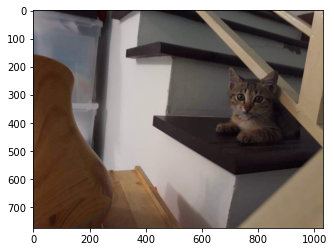

In [6]:
plt.imshow(img)


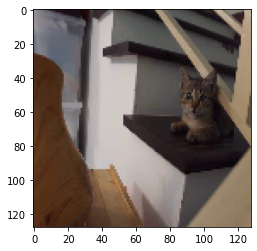

In [7]:
IMG_SIZE = 128
colours = 3
new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_img)

In [8]:
element_number = 9912
all_id = all_id[:element_number]
len(all_id)
df = df[:element_number]
df.iloc[-1]

Id               fff8e47c766799c9e12f3cb3d66ad228
Subject Focus                                   0
Eyes                                            1
Face                                            1
Near                                            1
Action                                          0
Accessory                                       0
Group                                           0
Collage                                         0
Human                                           0
Occlusion                                       0
Info                                            0
Blur                                            0
Pawpularity                                    30
Name: 9911, dtype: object

In [9]:
pictures = np.zeros((len(all_id), IMG_SIZE, IMG_SIZE, colours))
pictures.shape

(9912, 128, 128, 3)

In [10]:
for i, data_id in tqdm.tqdm(enumerate(all_id)):
    img = cv2.cvtColor(cv2.imread(f"Data/train/{df['Id'][i]}.jpg"), cv2.COLOR_BGR2RGB)
    new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    pictures[i] = new_img/255
#     plt.imshow(pictures[i])
#     plt.savefig(f'picture{i}.png')

9912it [01:38, 100.68it/s]


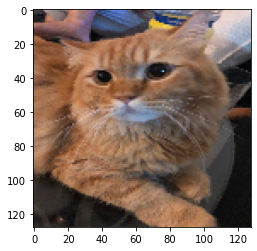

In [11]:
plt.imshow(pictures[8])

In [12]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

model_2.compile(loss=tf.keras.losses.mae, optimizer="nadam", metrics=["mse"])

history_1 = model_2.fit(pictures, df['Pawpularity']  , epochs=3)

Epoch 1/3
310/310 [==============================] - 392s 1s/step - loss: 19.2865 - mse: 1052.4987
Epoch 2/3
310/310 [==============================] - 388s 1s/step - loss: 17.0437 - mse: 550.7894
Epoch 3/3
310/310 [==============================] - 389s 1s/step - loss: 16.8415 - mse: 536.3394


In [19]:
df_test = pd.read_csv('Data/test.csv')
img = cv2.cvtColor(cv2.imread(f"Data/train/{df_test['Id'][0]}.jpg"), cv2.COLOR_BGR2RGB)

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
